In [1]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from utilities import aggregate_feature_calculators
from utilities import aggregate_feature_calculators_setting as aggcal
from utilities.parallel import Parallel

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import copy

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [4]:
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_colwidth', -1)

In [4]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v4
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v4.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [13]:
file_folder = 'data/input/champs-scalar-coupling' if 'champs-scalar-coupling' in os.listdir('../data/input/') else '../data/input'
os.listdir(file_folder)

['sample_submission.csv',
 'magnetic_shielding_tensors.csv',
 'potential_energy.csv',
 'scalar_coupling_contributions.csv',
 'dipole_moments.csv',
 'mulliken_charges.csv',
 'train.csv',
 'test.csv',
 'structures.csv',
 'structures']

In [14]:
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
magnetic_shielding_tensors = pd.read_csv(f'{file_folder}/magnetic_shielding_tensors.csv')
dipole_moments = pd.read_csv(f'{file_folder}/dipole_moments.csv')
mulliken_charges = pd.read_csv(f'{file_folder}/mulliken_charges.csv')
potential_energy = pd.read_csv(f'{file_folder}/potential_energy.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [20]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000


In [15]:
magnetic_shielding_tensors.head(2)

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.314999999999998,0.0000,-0.0001,0.0000,195.317000000000007,0.0007,-0.0001,0.0007,195.317000000000007
1,dsgdb9nsd_000001,1,31.340999999999998,-1.2317,4.0544,-1.2317,28.954599999999999,-1.7173,4.0546,-1.7173,34.086100000000002


In [16]:
dipole_moments.head(2)

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256


In [17]:
mulliken_charges.head(2)

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921


In [18]:
potential_energy.head(2)

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.523679999999999
1,dsgdb9nsd_000002,-56.560250000000003


In [19]:
scalar_coupling_contributions.head(2)

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.022400000000005,0.254579,1.25862,0.27201
1,dsgdb9nsd_000001,1,2,2JHH,-11.034700000000001,0.352978,2.85839,-3.43360


In [7]:
train_molecule_names = train['molecule_name'].unique().tolist()[:10] + ['dsgdb9nsd_133881']
test_molecule_names = test['molecule_name'].unique().tolist()[:10]
train = train[train['molecule_name'].isin(train_molecule_names)]
test = test[test['molecule_name'].isin(test_molecule_names)]
magnetic_shielding_tensors = magnetic_shielding_tensors[magnetic_shielding_tensors['molecule_name'].isin(train_molecule_names+test_molecule_names)]
dipole_moments = dipole_moments[dipole_moments['molecule_name'].isin(train_molecule_names+test_molecule_names)]
mulliken_charges = mulliken_charges[mulliken_charges['molecule_name'].isin(train_molecule_names+test_molecule_names)]
potential_energy = potential_energy[potential_energy['molecule_name'].isin(train_molecule_names+test_molecule_names)]
scalar_coupling_contributions = scalar_coupling_contributions[scalar_coupling_contributions['molecule_name'].isin(train_molecule_names+test_molecule_names)]
structures = structures[structures['molecule_name'].isin(train_molecule_names+test_molecule_names)]

In [8]:
# * fc is the Fermi Contact contribution
# * sd is the Spin-dipolar contribution
# * pso is the Paramagnetic spin-orbit contribution
# * dso is the Diamagnetic spin-orbit contribution

In [9]:
# @gilbertomrsilva tools to calculate features like bond angles, bending angles, dihedral angles, dipole moments, coupling partners and so on?

# 1) MolMod can read XYZ, calculate connection matrices, bond and dihedral angles and more https://github.com/molmod/molmod and documentation https://molmod.github.io/molmod/tutorial/internal_coordinates.html
# 2) OpenBabel to to read and convert XYZ https://github.com/openbabel
# 3) RDkit can do many many things https://github.com/rdkit/rdkit
# Use search function for dihedral angle such as http://www.rdkit.org/docs/source/rdkit.Chem.rdMolTransforms.html?highlight=dihedral#rdkit.Chem.rdMolTransforms.GetDihedralDeg

In [6]:
# features from two itom position
# edge level features
def structure_features(df, structures):

    df = copy.deepcopy(df)

    def _map_atom_info(df, structures, atom_idx):
        df = pd.merge(df, structures, how = 'left', left_on  = ['molecule_name', f'atom_index_{atom_idx}'], right_on = ['molecule_name',  'atom_index'])
        df = df.drop('atom_index', axis=1)
        df = df.rename(columns={'atom': f'atom_{atom_idx}', 'x': f'x_{atom_idx}', 'y': f'y_{atom_idx}', 'z': f'z_{atom_idx}'})
        return df
    
    def _create_features_full(df):
        df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
        df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
        df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
        df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
        df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
        df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
        df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

        num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
        cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
        aggs = ['mean', 'max', 'std', 'min']
        for col in cat_cols:
            df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

        for cat_col in tqdm_notebook(cat_cols):
            for num_col in num_cols:
                for agg in aggs:
                    df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                    df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                    df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]

        df = reduce_mem_usage(df)
        return df

    def _create_features(df):
        df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
        df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
        df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
        df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
        df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
        df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
        df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
        df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
        df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
        df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
        df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
        df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
        df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
        df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
        df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
        df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
        df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
        df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
        df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
        df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
        df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
        df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
        df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
        df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
        df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
        df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
        df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
        df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
        df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
        df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
        df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
        df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
        df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
        df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
        df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
        df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
        df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
        df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
        df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
        df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
        df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
        df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
        df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
        df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
        df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
        df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
        df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
        df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
        df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
        df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
        df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
        df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
        df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
        df = reduce_mem_usage(df)
        return df

    df = _map_atom_info(df, structures, 0)
    df = _map_atom_info(df, structures, 1)

    # distance between p0 to p1
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    # split type number and chars
    df['type_0'] = df['type'].apply(lambda x: x[0])
    df['type_1'] = df['type'].apply(lambda x: x[1:])
    # fraction dist / some mean
    df['dist_to_type_mean'] = df['dist'] / df.groupby('type')['dist'].transform('mean')
    df['dist_to_type_0_mean'] = df['dist'] / df.groupby('type_0')['dist'].transform('mean')
    df['dist_to_type_1_mean'] = df['dist'] / df.groupby('type_1')['dist'].transform('mean')
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df = _create_features(df)
    
    return df

# features from edge
# edge features

# angle
def add_cos_features(df):
    
    df = copy.deepcopy(df)
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    
    def _map_atom_info(df_1,df_2, atom_idx):
        df = pd.merge(df_1, df_2, how = 'left',
                      left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                      right_on = ['molecule_name',  'atom_index'])
        df = df.drop('atom_index', axis=1)

        return df
    
    def _func_a(df_train):
        #I apologize for my poor coding skill. Please make the better one.
        df_temp=df_train.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
        df_temp_=df_temp.copy()
        df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                           'atom_index_1': 'atom_index_0',
                                           'x_0': 'x_1',
                                           'y_0': 'y_1',
                                           'z_0': 'z_1',
                                           'x_1': 'x_0',
                                           'y_1': 'y_0',
                                           'z_1': 'z_0'})
        df_temp=pd.concat((df_temp,df_temp_),axis=0)

        df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
        df_temp= df_temp[df_temp["min_distance"]==df_temp["distance"]]

        df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
        df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index', 
                                         'atom_index_1': 'atom_index_closest',
                                         'distance': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})

        for atom_idx in [0,1]:
            df_train = _map_atom_info(df_train,df_temp, atom_idx)
            df_train = df_train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                                'distance_closest': f'distance_closest_{atom_idx}',
                                                'x_closest': f'x_closest_{atom_idx}',
                                                'y_closest': f'y_closest_{atom_idx}',
                                                'z_closest': f'z_closest_{atom_idx}'})
        return df_train
    
    df = _func_a(df)
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df

In [7]:
feats1_train = structure_features(train, structures)
feats1_train = add_cos_features(feats1_train)

Mem. usage decreased to 888.47 Mb (67.5% reduction)


In [8]:
feats1_test = structure_features(test, structures)
feats1_test = add_cos_features(feats1_test)

Mem. usage decreased to 463.56 Mb (68.1% reduction)


In [9]:
feats1_train.to_pickle('../data/feats/feats1.pkl')

In [10]:
feats1_test.to_pickle('../data/feats/feats1_test.pkl')

In [14]:
print(feats1_train.shape)
feats1_train.head()

(106, 76)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,type_1,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean,molecule_type_dist_mean,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8125000,H,0.00214958190918,-0.006031036376953,0.001976013183594,C,-0.01269531250,1.0859375000,0.008003234863281,1.091796875,0.000220537185669,1.192382812500,0.000036299228668,1,JHC,0.99853515625,1.0107421875,0.64599609375,1.091796875,10,1.5068359375,1.091796875,1.783203125,4,4,0.728027343750,1.3583984375,0.27294921875000,1.25097656250,1.4638671875,0.377929687500000,0.1822509765625,0.72802734375,1.6103515625,0.5185546875000,1.4746093750,1.783203125,0.691406250000000,1.6328125,1.091796875,0.00000000,1.0000000000,0.345703125000,-0.74658203125,0.316406250000,1.091796875,-0.000003397464752,1.0,1.091796875,0.000000000000000,1.0,1.091796875,-0.000006675720215,1.0,0.000003218650818,-1.091796875,0.000002920627594,1.091796875,1.091796875,-0.000006675720215,1.0,0.000003218650818,-1.091796875,0.000003218650818,-1.091796875,-0.000003397464752,1.0,1.091796875,1.091796875,0.000003218650818,-1.091796875
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2578125,H,0.00214958190918,-0.006031036376953,0.001976013183594,H,1.01171875000,1.4638671875,0.000276565551758,1.783203125,1.019531250000000,2.160156250000,0.000002861022949,2,JHH,1.01953125000,0.9306640625,0.85253906250,1.783203125,10,1.5068359375,1.091796875,1.783203125,4,1,0.728027343750,1.3583984375,-0.10498046875000,0.92822265625,1.4638671875,0.000000000000000,0.1822509765625,0.72802734375,1.6103515625,-0.1727294921875,0.9033203125,1.783203125,0.000036954879761,1.0000000,1.091796875,-0.69140625,0.6123046875,0.345703125000,-1.43750000000,0.193847656250,1.783203125,0.000000000000000,1.0,1.783203125,0.000000000000000,1.0,1.783203125,0.000000000000000,1.0,NaN,NaN,NaN,1.783203125,1.783203125,0.000000000000000,1.0,0.000013768672943,-1.783203125,0.000013768672943,-1.783203125,0.000026583671570,1.0,1.783203125,1.783203125,0.000013768672943,-1.783203125
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2578125,H,0.00214958190918,-0.006031036376953,0.001976013183594,H,-0.54101562500,1.4472656250,-0.876464843750000,1.783203125,0.294921875000000,2.113281250000,0.771972656250000,2,JHH,1.01953125000,0.9306640625,0.85253906250,1.783203125,10,1.5068359375,1.091796875,1.783203125,4,2,0.728027343750,1.3583984375,-0.08874511718750,0.93847656

In [ ]:
# encode the category columns
# for f in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
#     lbl = LabelEncoder()
#     lbl.fit(list(train[f].values) + list(test[f].values))
#     train[f] = lbl.transform(list(train[f].values))
#     test[f] = lbl.transform(list(test[f].values))

In [168]:
# def features(df, df2):
#     for c in ['mulliken_charge', 'fc', 'sd', 'pso', 'dso', 'dist', 'dist_to_type_mean']:
#         for agg in ['min', 'max', 'sum', 'mean']:
#             tmp = eval('df.groupby(["type"], as_index=False)[c].' + agg + '().rename(columns={"' + c + '":"' + agg + '"+ "_" +"' + c + '"})')
#             df = pd.merge(df, tmp, how='left', on=['type'])
#             df2 = pd.merge(df2, tmp, how='left', on=['type'])
#     return df, df2

# train, test = features(train, test)
# print(train.shape, test.shape)
# (4658147, 47) (2505542, 47)
# def features(df):
#     for c in ['0', '1']:
#         col = [c1 + c  for c1 in ['x','y','z']]
#         for agg in ['min', 'max', 'sum', 'mean', 'std', 'skew', 'kurtosis']:
#             df[c+agg] = eval('df[col].' + agg + '(axis=1)')
#             df[c+'a'+agg] = eval('df[col].abs().' + agg + '(axis=1)')
#     return df

# train = features(train).fillna(0)
# test = features(test).fillna(0)
# print(train.shape, test.shape)

In [14]:
# features for dipole_moment, formal_charges, partial_charges
# molecule features

import openbabel as ob
# estimation-of-mulliken-charges-with-open-babel
# Build molecules from files.xyz



def _read_ob_molecule(molecule_name, datadir="../data/input/structures"):
    obConversion = ob.OBConversion()
    mol = ob.OBMol()
    path = f"{datadir}/{molecule_name}.xyz"
    if not obConversion.ReadFile(mol, path):
        raise FileNotFoundError(f"Could not read molecule {path}")
    return mol

def _worker(item, ob_methods=None):

    index = item[0]
    molecule_name = item[1]

    if type(ob_methods) == type(None):
        ob_methods = [ "eem", "mmff94", "gasteiger", "qeq", "qtpie",  "eem2015ha", "eem2015hm", "eem2015hn", "eem2015ba", "eem2015bm", "eem2015bn" ]
    
    mol = _read_ob_molecule(molecule_name)
    molecule_i_dict = {}
    molecule_i_dict['index'] = index
    molecule_i_dict['molecule_name'] = molecule_name
    for ob_method in ob_methods:
        ob_charge_model = ob.OBChargeModel.FindType(ob_method)
        ob_charge_model.ComputeCharges(mol)
        dipole_moment = ob_charge_model.GetDipoleMoment(mol)

        formal_charges_ = np.array(list(ob_charge_model.GetFormalCharges()))
        partical_charges_ = np.array(list(ob_charge_model.GetPartialCharges()))
        dipole_moment_ = np.array([dipole_moment.GetX(), dipole_moment.GetY(), dipole_moment.GetZ()])

        #dipole_moment
        feat_name = '{}_dipole_moment'.format(ob_method)
        molecule_i_dict['{}_x'.format(feat_name)] = dipole_moment_[0]
        molecule_i_dict['{}_y'.format(feat_name)] = dipole_moment_[1]
        molecule_i_dict['{}_z'.format(feat_name)] = dipole_moment_[2]
        agg_res = aggcal.aggregate_features(dipole_moment_)
        for res_i in agg_res:
            vals = list(res_i.values())
            molecule_i_dict['{}_{}_{}'.format(feat_name, vals[0], vals[1])] = vals[2]

        #formal_charges
        feat_name = '{}_formal_charges'.format(ob_method)
        agg_res = aggcal.aggregate_features(formal_charges_)
        for res_i in agg_res:
            vals = list(res_i.values())
            molecule_i_dict['{}_{}_{}'.format(feat_name, vals[0], vals[1])] = vals[2]

        #partical_charges
        feat_name = '{}_partical_charges'.format(ob_method)
        agg_res = aggcal.aggregate_features(partical_charges_)
        for res_i in agg_res:
            vals = list(res_i.values())
            molecule_i_dict['{}_{}_{}'.format(feat_name, vals[0], vals[1])] = vals[2]
                
    return molecule_i_dict


def extract_dipole_moment_features(molecule_names):
    N_ = len(molecule_names)
    segment = N_//10
    df_ = pd.DataFrame()
    for start in tqdm_notebook(range(0, N_, segment)):
        end = start+segment if start+segment < N_ else N_
        res = Parallel(_worker,{}).run(enumerate(molecule_names[start:end]), n_jobs=16)
        df_ = pd.concat([df_, pd.DataFrame(res)], axis=0)
    df_ = df_.sort_values(by=['index'])
    return df_.drop(columns=['index'])

In [15]:
feats2_train = extract_dipole_moment_features(train.molecule_name.unique())

In [16]:
feats2_test = extract_dipole_moment_features(test.molecule_name.unique())

In [17]:
feats2_train.to_pickle('../data/feats/feats2.pkl')
feats2_test.to_pickle('../data/feats/feats2_test.pkl')

In [77]:
# feats1 = pd.merge(feats1_train, feats2, how = 'left', left_on  = ['molecule_name'], right_on = ['molecule_name'])

In [ ]:
# #mlp a-neural-network-approach predict middle variable first

# def nn_model() :
#     i  = Input(shape = (16,))
#     # Initial Block
#     x  = Dense(64,activation = 'relu')(i)
#     x  = Dense(32,activation = 'relu')(x)
#     x  = Dense(16,activation = 'relu')(x)
    
#     # Mulliken Charge 0 Block
#     x1 = Dense(64,activation = 'relu')(i)
#     x1 = Dense(32,activation = 'relu')(x1)
#     x1 = Dense(16,activation = 'relu')(x1)
    
#     x1_output = Dense(1,activation = 'linear',name = 'mulliken_charge_0')(x1)
    
    
#     # Mullikem Charge 1 Block
#     x2 = Dense(64,activation = 'relu')(i)
#     x2 = Dense(32,activation = 'relu')(x2)
#     x2 = Dense(16,activation = 'relu')(x2)
    
#     x2_output = Dense(1,activation = 'linear',name = 'mulliken_charge_1')(x2)
    
#     # Dipole Moment Block
#     x3 = Dense(64,activation = 'relu')(i)
#     x3 = Dense(32,activation = 'relu')(x3)
#     x3 = Dense(16,activation = 'relu')(x3)
    
#     x3_output = Dense(1,activation = 'linear',name = 'dipole_moment')(x3)
    
#     concat = concatenate([x,x1_output,x2_output,x3_output])
    
#     # Scalar Coupling Constant Block
#     x4 = Dense(64,activation = 'relu')(concat)
#     x4 = Dense(32,activation = 'relu')(x4)
    
#     x4_output = Dense(1,activation = 'linear',name = 'scaler_coupling_constant')(x4)
    
    
#     return Model(inputs = [i] , outputs = [x4_output,x3_output,x2_output,x1_output])
# model = nn_model()
# model.compile(loss='mean_absolute_error', optimizer='adam')
# model.summary()

# history = model.fit(x = train,y = [scalar_coupling_constant.values,dipole_moment.values,mulliken_charge_1.values,mulliken_charge_0.values],
#                     validation_split=0.1,epochs=150,verbose=1,batch_size = 128)

In [ ]:
# # Easy Visualization of Molecules

# from ase import Atoms
# import ase.visualize

# system = Atoms(positions=atoms, symbols=symbols)

# ase.visualize.view(system, viewer="x3d")

In [ ]:
# # maybe corelation work?
# scalar_index_cross = ['atom_index_0', 'atom_index_1'] #seting the desired 

# cm = sns.light_palette("green", as_cmap=True)
# pd.crosstab(df_train[scalar_index_cross[0]], df_train[scalar_index_cross[1]],  values=df_train['scalar_coupling_constant'], aggfunc=['mean']).style.background_gradient(cmap = cm)

In [ ]:
# # speed up

# %%time
# # Engineer a single feature: distance vector between atoms
# #  (there's ways to speed this up!)

# def dist(row):
#     return ( (row['x_1'] - row['x_0'])**2 +
#              (row['y_1'] - row['y_0'])**2 +
#              (row['z_1'] - row['z_0'])**2 ) ** 0.5

# train['dist'] = train.apply(lambda x: dist(x), axis=1)
# test['dist'] = test.apply(lambda x: dist(x), axis=1)
# CPU times: user 7min 18s, sys: 2.74 s, total: 7min 21s
# Wall time: 7min 21s
# %%time
# # This block is SPPED UP

# train_p_0 = train[['x_0', 'y_0', 'z_0']].values
# train_p_1 = train[['x_1', 'y_1', 'z_1']].values
# test_p_0 = test[['x_0', 'y_0', 'z_0']].values
# test_p_1 = test[['x_1', 'y_1', 'z_1']].values

# train['dist_speedup'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
# test['dist_speedup'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
# CPU times: user 540 ms, sys: 872 ms, total: 1.41 s
# Wall time: 1.4 s
    

In [ ]:
# coupling type 
# train.type.unique()
# array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
#       dtype=object)
# There are only 8 different possible couplings types. The coupling type starts with a number 1, 2 or 3 and is relative to the number of bonds involved. It will be plotted with

# black (transparent) line for 1 bond coupling
# green dashed (transparent) line for two bonds coupling
# red dotted (transparent) line for three bond coupling

In [ ]:
# # make categorical variables
# atom_map = {'H': 0, 'C': 1, 'N': 2}
# train_df['atom_0_cat'] = train_df['atom_0'].map(atom_map).astype('int')
# train_df['atom_1_cat'] = train_df['atom_1'].map(atom_map).astype('int')
# test_df['atom_0_cat'] = test_df['atom_0'].map(atom_map).astype('int')
# test_df['atom_1_cat'] = test_df['atom_1'].map(atom_map).astype('int')
# # One Hot Encode the Type
# train_df = pd.concat([train_df, pd.get_dummies(train_df['type'])], axis=1)
# test_df = pd.concat([test_df, pd.get_dummies(test_df['type'])], axis=1)

In [18]:

# dataset-with-number-of-bonds-between-atoms
# features from atom
# atom features

from ase import Atoms  # 3D mouse clickable funky visualization
import ase.visualize
import networkx as nx # for cycle detection

"""
Select a molecule
STEP 1 : 1-bond connect
For each atom
For each #VALENCE closest match:
does the distance correspond to the expected bond distance?
does both atoms have remaining bonds?
decease remaining valence and create bond
mark both atoms as leaf if one of them has zero remaining valence
STEP 2 : n-bond greedy connect
While there are remaining leafs atoms with available valence
For each connected neighbour
add as many bonds as possible
mark both connected atoms as leaf
STEP 3 : ionized radical search If there are remaining valence on some atoms
Look for disconnected NH3 => convert to connected NH3+
Look for O with one available bond connected to CO => convert to COO-
Other cases may be handled later
STEP 4 : cycle search
Use networkx pip library for shortest cycle detection
Index atoms by order in their respective cycle
CHECK
Has any atom remaining valence > 0?
mark the molecule with error=1
"""

from scipy.spatial import cKDTree as KDTree
from tqdm import tqdm_notebook as tqdm


# "usual" valence of atoms

# VALENCE = { 'C': 4, 'H' : 1, 'N' : 4, 'O' : 2, 'F': 1 }

VALENCE_MAX = { 'C': 4, 'H' : 1, 'N' : 4, 'O' : 2, 'F': 1 }
VALENCE_STD = { 'C': 4, 'H' : 1, 'N' : 3, 'O' : 2, 'F': 1 }
# expected distances in [A] for covalence 1 bond
BOND_DIST_C1 = { 'C' : 0.77, 'H' : 0.38, 'N' : 0.75, 'O' : 0.73, 'F' : 0.71 }
# order used for finding bonds by atom type
BOND_ORDER = { 'H' : 0, 'F' : 0, 'O' : 1, 'N' : 2, 'C' : 3}

def add_bond(n_avail, nbond, a0, a1, d1=None):
    key = tuple(sorted((a0, a1)))
    if key in nbond:
        nbond[key][0] += 1.0
    elif d1 is not None:
        nbond[key] = [1.0, d1]
    else:
        raise Exception(f"{a0},{a1} added after phase 1")
    n_avail[a0] -= 1
    n_avail[a1] -= 1
    #display(f"{a0},{a1} => {n_avail}, {nbond}")

def get_bonded_atoms(atoms, nbond, i):
    """returns: [sorted atoms list], [sorted atom index] )"""
    bonded = []
    for (a0, a1), (n, _) in nbond.items():
        if a0 == i:
            bonded.append((a1, atoms[a1]))
        elif a1 == i:
            bonded.append((a0, atoms[a0]))
    bonded = sorted(bonded, key=lambda b: b[1])
    return "".join([b[1] for b in bonded]), [b[0] for b in bonded]


def search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx, a0, connect_once=True, VALENCE=VALENCE_STD):
    atom0 = atoms[a0]
    if n_avail[a0] == 0:
        return

    # select closest atoms ORDERED BY DISTANCE: closest first
    # note: the first answer is the atom itself and must be removed
    next_dist, next_i = kdt.query(coords[a0], min(1+VALENCE[atom0], len(atoms)))
    next_dist = next_dist[1:]; # remove a0 from list
    next_i = next_i[1:]

    # for each #VALENCE closest atoms
    found = False
    for d1,a1 in zip(next_dist, next_i):
        if connect_once and (a1 in connected[a0]):
            continue  # enforce 1-bond only in STEP 1
        atom1 = atoms[a1]
        predicted_bond = BOND_DIST_C1[atom0] + BOND_DIST_C1[atom1]
        if abs(d1 / predicted_bond) < 1.2: # keep only atoms in the 20% expected distance or closer
            if n_avail[a1] > 0:
                add_bond(n_avail, nbond, a0, a1, d1)
                connected[a0][a1] = 1
                connected[a1][a0] = 1
                if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                    isleaf[a0] = 1
                    isleaf[a1] = 1
                found = True
                #print("leaF/Trunk & avail: "+ ", ".join([f"{i}:{atoms[i]}={leaflabel[isleaf[i]]}{n_avail[i]}"
                #                 for i in ordered_atoms_index]))
        else:
            #print(f"-- match failure in molecule_name={name} {a0}:{atom0}-{a1}:{atoms[a1]}={d1} predicted={predicted_bond}")
            pass
    return found
    
def compute_bonds(structures, molecules):
    
    
    out_name = []; out_a0 = []; out_a1 = []; out_n = []; out_dist = []; out_error = []; out_type = []
    cycle_name = []; cycle_index = []; cycle_seq = [];  cycle_atom_index = []
    charge_name = []; charge_atom_index = []; charge_value = [];
    
    
    for imol,name in tqdm(list(enumerate(molecules))):
        
        molecule = structures.loc[name]
        error    = 0
        atoms    = molecule.atom.values
        atoms_idx= molecule.atom_index.values
        
        n_avail  = np.asarray([VALENCE_STD[a] for a in atoms])
        n_charge = np.zeros(len(atoms), dtype=np.float16)
        isleaf   = np.zeros(len(atoms), dtype=np.bool) # is the atom in the leafs of connection tree?
        coords   = molecule[['x', 'y', 'z']].values
        kdt = KDTree(coords) # use an optimized structure for closest match query
        nbond = {}
        connected = { i:{} for i in atoms_idx}
        
        # select Hydrogen first to avoid butadyne-like ordering failures (molecule_name=dsgdb9nsd_000023)
        ordered_atoms_index = list(atoms_idx)
        ordered_atoms_index.sort(key = lambda i: BOND_ORDER[atoms[i]])
        ordered_atoms_index = np.asarray(ordered_atoms_index)
        
        # STEP 1: 1-bond connect each atom with closest match
        #         only one bond for each atom pair is done in step 1
        for a0 in ordered_atoms_index:
            search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx, a0, connect_once=True, VALENCE=VALENCE_STD)
     
        # STEP 2: greedy connect n-bonds, progressing from leafs of connection tree
        while (((n_avail > 0).sum() > 0) and isleaf).sum() > 0:
            progress = False
            for a0 in ordered_atoms_index:
                #print("leaF/Trunk & avail: " + ", ".join([f"{i}:{atoms[i]}={leaflabel[leaf[i]]}{n_avail[i]}"
                #                                          for i in ordered_atoms_index]))
                if (n_avail[a0] > 0) and isleaf[a0]:
                    for a1 in connected[a0]:
                        if (n_avail[a0] > 0) and (n_avail[a1] > 0):
                            add_bond(n_avail, nbond, a0, a1) 
                            progress = True
                            if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                                isleaf[a0] = 1
                                isleaf[a1] = 1
            if not progress:
                break
        
        # gather remaining multiple bonds
        if n_avail.sum() > 0:
            for key in nbond.keys():
                a0, a1 = key
                while (n_avail[a0] > 0) and (n_avail[a1] > 0):
                    add_bond(n_avail, nbond, a0, a1)
    
        # STEP 3: search for known ionized radicals
        if n_avail.sum() > 0:
            for (i,a) in zip(atoms_idx, atoms):
                if a == 'N':
                    # NH3+
                    bonded_str, bonded_idx = get_bonded_atoms(atoms, nbond, i)
                    if (bonded_str == "HHH") and (n_avail[i] == 0):
                        # add a valence unit and search a dangling bond nearby
                        n_avail[i] += 1; n_charge[i] += 1
                        if search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx, i, connect_once=False, VALENCE=VALENCE_MAX):
                            pass
#                             print(f"++ NH3+ found for {name} atom_index={i}")
                        else:
#                             print(f"** NH3+ bonding failure for {name} atom_index={i}")
                            pass
                            
                elif (a == 'O') and (n_avail[i] == 1):
                    # COO-
                    bonded_str, bonded_idx = get_bonded_atoms(atoms, nbond, i)
                    if bonded_str == "C":
                        C_i = bonded_idx[0]
                        C_bonded_str, C_bonded_idx = get_bonded_atoms(atoms, nbond, C_i)
                        if ("OO" in C_bonded_str):
                            has_2CO = False 
                            #print (C_bonded_str, C_bonded_idx, nbond, name)
                            for a1, i1 in zip(C_bonded_str, C_bonded_idx):
                                key = tuple(sorted((C_i, i1)))
                                if (a1 == 'O') and  (nbond[key][0] == 2):
                                    has_2CO = True
                            if (len(C_bonded_idx) == 3) and has_2CO:
                                # found carboxyle!
                                n_avail[i] -= 1
#                                 print(f"**  COO- found for {name} C_atom_index={C_i}")
                                for a1, i1 in zip(C_bonded_str, C_bonded_idx):
                                    if a1 == 'O':
                                        n_charge[i1] = -0.5
                                        key = tuple(sorted((C_i, i1)))
                                        nbond[key][0] = 1.5                    
                                    
        # detect cycles : algo complexity in O(m^2 * n)
        #    paper : https://link.springer.com/article/10.1007/s00453-007-9064-z
        #    nx doc: https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.cycles.minimum_cycle_basis.html
        graph = nx.Graph([bond for bond in nbond.keys()])
        unordered_cycles = nx.minimum_cycle_basis(graph)
        
        # index atoms by their sequential order in the cycle: i.e follow bonds
        # Note: this code can be written in a much cleaner way!
        if len(unordered_cycles) > 0:
            for icycle, c in enumerate(unordered_cycles):
                available = {i:1 for i in c}
                a0 = c[0]
                cycle = [ a0 ]
                del(available[a0])
                for index in range(1, len(c)):
                    # get atoms bonded to a0
                    bonded = [ b for b in nbond.keys() if a0 in b ]
                    bonded = list(map(lambda b: b[0] if b[1] == a0 else b[1], bonded))
                    
                    # get next atom and remove it from cycle
                    assert(len(bonded) > 0)
                    found = False
                    for a1 in bonded:
                        if (a1 in bonded) and (a1 in available):
                            cycle.append(a1)
                            del(available[a1])
                            a0 = a1
                            found = True
                            break
                    assert(found)
                    
                # and add cycles found to the cycle dataframe lists
                cycle_name.extend([name] * len(cycle))
                cycle_index.extend([icycle] * len(cycle))
                cycle_seq.extend(np.arange(len(cycle)))
                cycle_atom_index.extend(cycle)
        
        # display info on failed molecules
        if n_avail.sum() > 0:
            error = 1
#             print(f"   Remaining bondings={n_avail.sum()} for molecule_name={name}, atoms: " + ", ".join([f"{i}:{atoms[i]}" for i in atoms_idx if n_avail[i] > 0]))

        # inputs for DataFrame bonds
        for (a0, a1), (n, dist) in nbond.items():
            # append to python lists which is 7x faster than toa pd.DataFrame
            out_name.append(name); 
            out_a0.append(a0); 
            out_a1.append(a1); 
            out_n.append(n)
            out_dist.append(dist); 
            out_error.append(error)
            out_type.append(f"{n:0.1f}" + "".join(sorted(f"{atoms[a0]}{atoms[a1]}")) )
    
        # inputs for DataFrame charges
        charge_name.extend([name] * len(atoms))
        charge_atom_index.extend(molecule.atom_index.values)
        charge_value.extend(n_charge)
        
    bonds = pd.DataFrame({'molecule_name':out_name, 'atom_index_0':out_a0,'atom_index_1':out_a1, 'nbond':out_n, 'L2dist':out_dist, 'error':out_error, 'bond_type':out_type})
    charges = pd.DataFrame({'molecule_name':charge_name, 'atom_index':charge_atom_index, 'charge': charge_value})
    cycles = pd.DataFrame({'molecule_name' : cycle_name, 'cycle_index' : cycle_index, 'cycle_seq' : cycle_seq, 'atom_index' : cycle_atom_index})
    return bonds, charges, cycles

In [19]:
bonds, charges, cycles = compute_bonds(structures.set_index('molecule_name'), train.molecule_name.unique().tolist() + test.molecule_name.unique().tolist() )

In [30]:
def _worker(item):
    
    idx = item[0]
    row = item[1]
    molecule_name_ = row['molecule_name']
    atom_index_ = row['atom_index']
    cycle_index_list_ = cycles[(cycles['molecule_name']==molecule_name_)&(cycles['atom_index']==atom_index_)].cycle_index.unique().tolist()
    n_cycle = len(cycle_index_list_)
    mean_cycle_atom = np.mean([cycles[(cycles['molecule_name']==molecule_name_) & (cycles['cycle_index']==cycle_index)].shape[0] for cycle_index in cycle_index_list_])
#     n_cycle_list.append(n_cycle)
#     mean_cycle_atom_list.append(mean_cycle_atom)
    return {'idx':idx, 'n_cycle':n_cycle, 'mean_cycle_atom':mean_cycle_atom}


def agg_cycles(cycles):
    cycles = copy.deepcopy(cycles)
    N_ = len(cycles)
    segment = N_//100
    df_ = pd.DataFrame()
    for start in tqdm_notebook(range(0, N_, segment)):
        end = start+segment if start+segment < N_ else N_
        res = Parallel(_worker,{}).run(cycles.loc[start:end].iterrows(), n_jobs=12)
        df_ = pd.concat([df_, pd.DataFrame(res)], axis=0)
    
    df_ = df_.sort_values(by=['idx'])
    df_ = df_.reset_index(drop=True)
    cycles = pd.concat([cycles, df_], axis=1)
    cycles = cycles[['molecule_name', 'atom_index', 'n_cycle', 'mean_cycle_atom']].drop_duplicates()
    return cycles

In [31]:
cycles = agg_cycles(cycles)

In [40]:
# bonds.to_pickle('../data/feats/bonds.pkl')
# charges.to_pickle('../data/feats/charges.pkl')
# cycles.to_pickle('../data/feats/cycles.pkl')

In [7]:
bonds = pd.read_pickle('../data/feats/bonds.pkl')
charges = pd.read_pickle('../data/feats/charges.pkl')
cycles = pd.read_pickle('../data/feats/cycles.pkl')

In [28]:
def _map_atom_charges(df, charges, atom_idx):
    df = pd.merge(df, charges, how = 'left', left_on  = ['molecule_name', f'atom_index_{atom_idx}'], right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'charge': f'atom_index_{atom_idx}_charge'})
    return df

def _map_atom_cycles(df, charges, atom_idx):
    df = pd.merge(df, charges, how = 'left', left_on  = ['molecule_name', f'atom_index_{atom_idx}'], right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'n_cycle': f'atom_index_{atom_idx}_n_cycle', 'mean_cycle_atom': f'atom_index_{atom_idx}_mean_cycle_atom'})
    return df

def _worker(item, edges, bonds):
    
    molecule_name = item
    list_ = []
    for edges_idx, edges_item in  edges[edges['molecule_name']==molecule_name].iterrows():
        try:

            is_found_bond = False
            for bonds_idx, bonds_item in  bonds[bonds['molecule_name']==molecule_name].iterrows():
                if (bonds_item['atom_index_0']==edges_item['atom_index_0']) & (bonds_item['atom_index_1']==edges_item['atom_index_1']):
                    is_found_bond = True
                    break
                elif (bonds_item['atom_index_0']==edges_item['atom_index_1']) & (bonds_item['atom_index_1']==edges_item['atom_index_0']):
                    is_found_bond = True
                    break
            if is_found_bond:
                dict_ = {'index':edges_idx, 'molecule_name':molecule_name, 'atom_index_0':edges_item['atom_index_0'], 'atom_index_1':edges_item['atom_index_1'], 
                         'is_found_bond':1, 'nbond':bonds_item['nbond'], 'L2dist': bonds_item['L2dist'], 'error':bonds_item['error'], 'bond_type':bonds_item['bond_type']}
            else:
                dict_ = {'index':edges_idx, 'molecule_name':molecule_name, 'atom_index_0':edges_item['atom_index_0'], 'atom_index_1':edges_item['atom_index_1'], 
                         'is_found_bond':0, 'nbond':0, 'L2dist': 0, 'error':0, 'bond_type':'none'}
            list_.append(dict_)
        except :
            raise Exception(edges_idx, bonds_idx, bonds_item)
    return list_

def search_bond(edges, bonds, molecule_names=None, path='../data/feats/search_bond.pkl'):
    
    if type(molecule_names)==type(None):
        molecule_names = list(edges['molecule_name'].unique())
    N_ = len(molecule_names)
    segment = N_//100
    
    if os.path.exists(path):
        df_ = pd.read_pickle(path)
        end_point = df_.molecule_name.unique().shape[0]-1
    else:
        df_ = pd.DataFrame()
        end_point = -1
    print(end_point)
    
    
    for start in tqdm_notebook(range(0, N_, segment)):
        end = start+segment if start+segment < N_ else N_
        if start<=end_point:
            continue
        
        res = Parallel(_worker,{'edges':edges, 'bonds':bonds}).run(molecule_names[start:end], n_jobs=16)
        df_ = pd.concat([df_, pd.DataFrame(res)], axis=0)
        df_.to_pickle(path)
    df_ = df_.sort_values(by=['index'])
    df_ = df_.reset_index(drop=True)
    return df_

In [18]:
feats3_train = search_bond(train, bonds)
feats3_train = _map_atom_charges(feats3_train, charges, 0)
feats3_train = _map_atom_charges(feats3_train, charges, 1)
feats3_train = _map_atom_cycles(feats3_train, cycles, 0)
feats3_train = _map_atom_cycles(feats3_train, cycles, 1)
feats3_train = feats3_train.fillna(0)

57800


Process ForkPoolWorker-39:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [41]:
# feats3_train = feats3_train.drop_duplicates(subset=['molecule_name','atom_index_0','atom_index_1'])
# feats3_train = feats3_train.sort_values(by=['index'])
# feats3_train = feats3_train.reset_index(drop=True)
# feats3_train.to_pickle('../data/feats/feats3_train.pkl')

In [29]:
feats3_test = search_bond(test, bonds)
feats3_test = _map_atom_charges(feats3_test, charges, 0)
feats3_test = _map_atom_charges(feats3_test, charges, 1)
feats3_test = _map_atom_cycles(feats3_test, cycles, 0)
feats3_test = _map_atom_cycles(feats3_test, cycles, 1)
feats3_test = feats3_test.fillna(0)

12795


In [36]:
# feats3_test = feats3_test.drop_duplicates(subset=['molecule_name','atom_index_0','atom_index_1'])
# feats3_test = feats3_test.sort_values(by=['index'])
# feats3_test = feats3_test.reset_index(drop=True)
# feats3_test.to_pickle('../data/feats/feats3_test.pkl')

In [37]:
feats3_test.shape, test.shape

((2505542, 15), (2505542, 5))

In [7]:
# features from atom
# atom features

"""
Read and preprocess structure data

The most important step here for bond detection is the addition of the atomic radius values. There are several different definitions of atomic radius, 
but the most relevant in this situation is the radius of a single covalent bond. 
Wikipedia maintains a table with this value at https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page). 
    I increased the values slightly in order to reduce false negatives. Atoms that are not bonded repel each other, so it should be rare that this increase will result in false positives.
    
"""

def compute_bonds2(structures):

    atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor
    fudge_factor = 0.05
    atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
    electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#     structures = pd.read_csv(STRUCTURES_CSV, dtype={'atom_index':np.int8})

    atoms = structures['atom'].values
    atoms_en = [electronegativity[x] for x in atoms]
    atoms_rad = [atomic_radius[x] for x in atoms]

    structures['en'] = atoms_en
    structures['rad'] = atoms_rad


    # bond
    i_atom = structures['atom_index'].values
    p = structures[['x', 'y', 'z']].values
    p_compare = p
    m = structures['molecule_name'].values
    m_compare = m
    r = structures['rad'].values
    r_compare = r

    source_row = np.arange(len(structures))
    max_atoms = 28

    bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
    bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

    for i in tqdm(range(max_atoms-1)):
        
        p_compare = np.roll(p_compare, -1, axis=0)
        m_compare = np.roll(m_compare, -1, axis=0)
        r_compare = np.roll(r_compare, -1, axis=0)

        mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
        dists = np.linalg.norm(p - p_compare, axis=1) * mask
        r_bond = r + r_compare

        bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)

        source_row = source_row
        target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
        target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row

        source_atom = i_atom
        target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
        target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col

        bonds[(source_row, target_atom)] = bond
        bonds[(target_row, source_atom)] = bond
        bond_dists[(source_row, target_atom)] = dists
        bond_dists[(target_row, source_atom)] = dists

    bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
    bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
    bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
    bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

    bonds_numeric = [[i for i,x in enumerate(row) if x] for row in bonds]
    bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j, row in enumerate(bond_dists)]
    n_bonds = [len(x) for x in bonds_numeric]

    bond_data = {'bonds':bonds_numeric, 'n_bonds':n_bonds, 'bond_lengths':bond_lengths}
    bond_df = pd.DataFrame(bond_data)
    bond_df['molecule_name'] = structures['molecule_name']
    bond_df['atom_index'] = structures['atom_index']
    bond_df['atom'] = structures['atom']
    
    return bond_df

In [43]:
bonds2 = compute_bonds2(structures)

100%|██████████| 27/27 [00:09<00:00,  3.16it/s]


In [46]:
# bonds2.to_pickle('../data/feats/bonds2.pkl')

In [7]:
bonds2 = pd.read_pickle('../data/feats/bonds2.pkl')

In [49]:
bonds2.atom.unique()

array(['C', 'H', 'N', 'O', 'F'], dtype=object)

In [9]:
print(bonds2.shape)
bonds2.head()

(2358657, 6)


,bonds,n_bonds,bond_lengths,molecule_name,atom_index,atom
0,"[1, 2, 3, 4]",4,"[1.091953, 1.0919516, 1.0919464, 1.0919476]",dsgdb9nsd_000001,0,C
1,[0],1,[1.091953],dsgdb9nsd_000001,1,H
2,[0],1,[1.0919516],dsgdb9nsd_000001,2,H
3,[0],1,[1.0919464],dsgdb9nsd_000001,3,H
4,[0],1,[1.0919476],dsgdb9nsd_000001,4,H


In [10]:
bonds2['bonds_std'] = bonds2['bonds'].apply(lambda x : np.std(x))
bonds2['bonds_mean'] = bonds2['bonds'].apply(lambda x : np.mean(x))
bonds2['bond_lengths_mean'] = bonds2['bond_lengths'].apply(lambda x : np.mean(x))
bonds2['bond_lengths_std'] = bonds2['bond_lengths'].apply(lambda x : np.std(x))

In [15]:
bonds2.head()

,bonds,n_bonds,bond_lengths,molecule_name,atom_index,atom,bonds_std,bonds_mean,bond_lengths_mean,bond_lengths_std
0,"[1, 2, 3, 4]",4,"[1.091953, 1.0919516, 1.0919464, 1.0919476]",dsgdb9nsd_000001,0,C,1.118033988749895,2.5,1.091949701309204,0.00000276246783
1,[0],1,[1.091953],dsgdb9nsd_000001,1,H,0.000000000000000,0.0,1.091953039169312,0.00000000000000
2,[0],1,[1.0919516],dsgdb9nsd_000001,2,H,0.000000000000000,0.0,1.091951608657837,0.00000000000000
3,[0],1,[1.0919464],dsgdb9nsd_000001,3,H,0.000000000000000,0.0,1.091946363449097,0.00000000000000
4,[0],1,[1.0919476],dsgdb9nsd_000001,4,H,0.000000000000000,0.0,1.091947555541992,0.00000000000000


In [16]:
feats4 = bonds2[['molecule_name', 'atom_index', 'atom', 'n_bonds', 'bonds_std','bonds_mean','bond_lengths_mean','bond_lengths_std']]

In [19]:
feats4.rename(columns={'n_bonds':'bonds2_n_bonds', 'bonds_std':'bonds2_bonds_std', 'bonds_mean':'bonds2_bonds_mean', 'bond_lengths_mean':'bonds2_bond_lengths_mean', 'bond_lengths_std':'bonds2_bond_lengths_std'}, inplace=True)

In [20]:
feats4.head()

,molecule_name,atom_index,atom,bonds2_n_bonds,bonds2_bonds_std,bonds2_bonds_mean,bonds2_bond_lengths_mean,bonds2_bond_lengths_std
0,dsgdb9nsd_000001,0,C,4,1.118033988749895,2.5,1.091949701309204,0.00000276246783
1,dsgdb9nsd_000001,1,H,1,0.000000000000000,0.0,1.091953039169312,0.00000000000000
2,dsgdb9nsd_000001,2,H,1,0.000000000000000,0.0,1.091951608657837,0.00000000000000
3,dsgdb9nsd_000001,3,H,1,0.000000000000000,0.0,1.091946363449097,0.00000000000000
4,dsgdb9nsd_000001,4,H,1,0.000000000000000,0.0,1.091947555541992,0.00000000000000


In [21]:
feats4.to_pickle('../data/feats/feats4.pkl')

In [12]:
def _worker(item, bonds2):
    
    molecule_name = item
    list_ = []
    c_counts = 0
    h_counts = 0
    n_counts = 0
    o_counts = 0
    f_counts = 0
    for bonds2_idx, bonds2_item in  bonds2[bonds2['molecule_name']==molecule_name].iterrows():
        
        for bonded_atom_index in bonds2_item['bonds']:
            atom_ = bonds2[(bonds2['molecule_name']==molecule_name)&(bonds2['atom_index']==bonded_atom_index)]['atom'].values[0]
            if atom_=='C':
                c_counts += 1
            elif atom_=='H':
                h_counts += 1
            elif atom_=='N':
                n_counts += 1
            elif atom_=='O':
                o_counts += 1
            elif atom_=='F':
                f_counts += 1
        
        list_.append({'molecule_name':molecule_name, 'atom_index':bonds2_item['atom_index'], 'c_counts':c_counts, 'h_counts':h_counts, 'n_counts':n_counts, 'o_counts':o_counts, 'f_counts':f_counts})

    return list_

def bond2_transform(bonds2, molecule_names=None, path='../data/feats/bonds2_transform.pkl'):
    
    if type(molecule_names)==type(None):
        molecule_names = list(bonds2['molecule_name'].unique())
        
    if os.path.exists(path):
        df_ = pd.read_pickle(path)
    else:
        df_ = pd.DataFrame()
        
    done_molecule_names = df_.molecule_name.unique().tolist() if df_.shape[0]!=0 else []
    reminder_molecule_names = list(set(molecule_names)-set(done_molecule_names))
    N_ = len(reminder_molecule_names)
    segment = N_//100
    if segment<1:
        segment = 1
    print(len(done_molecule_names))
    for start in tqdm_notebook(range(0, N_, segment)):
        end = start+segment if start+segment < N_ else N_
        res = Parallel(_worker,{'bonds2':bonds2}).run(reminder_molecule_names[start:end], n_jobs=16)
        df_ = pd.concat([df_, pd.DataFrame(res)], axis=0)
        df_.to_pickle(path)
    df_ = df_.sort_values(by=['index'])
    df_ = df_.reset_index(drop=True)
    df_.to_pickle(path)
    return df_

In [ ]:
bonds2_transform = bond2_transform(bonds2)

13070


In [156]:
train.id.unique().shape

(106,)

In [27]:
train.id.unique().shape,train.shape

((4658147,), (4658147, 6))

In [71]:
# features from edge
# edge features

"""
https://www.kaggle.com/bigironsphere/molecular-geometry-feature-engineering-eda
"""

from numpy.linalg import svd
import math
#quick PCA via singular value decomp - obtain principal eigenvector of molecule axis

def _PCA_SVD(a):
    a_mean = a.mean(axis=1)
    #normalise
    a = (a.T - a_mean.T).T
    u, s, v = svd(a.T)
    return(v[0])

#obtain plane with minimum sum distance from nuclei
def _get_plane(a):
    a = np.reshape(a, (a.shape[0], -1))
    centroid = a.mean(axis=1)
    #normalise
    x = a - centroid[:,np.newaxis]
    m = np.dot(x, x.T) 
    return(centroid, svd(m)[0][:,-1])

def _compute_bonds3_worker(item, df_bonds, df_structure):
    
    mol = item
    #obtain structure and bond information for each molecule
    temp_struct = df_structure.loc[df_structure.molecule_name==mol, :]
    bonds = df_bonds.loc[df_bonds.molecule_name == mol, :]
    
    size_list = []
    flatness = []
    bond_angle_plane = []
    bond_angle_axis = []

    #number of constituent atoms
    size = len(temp_struct)
    size_list.extend(np.full(len(bonds), size))

    #nuclei coords
    coords = np.column_stack([temp_struct.x.values, temp_struct.y.values, temp_struct.z.values]).T

    #principal axis of molecular alignment
    axis_vector = _PCA_SVD(coords)

    #obtain flatness metric and plane angles for binds if nuclei > 3
    if size > 3:

        coords = coords - coords.mean()
        #calculate best fitting 2D plane
        ctr, norm = _get_plane(coords) 

        #calculate distances of each atom from plane
        dists = np.zeros(size)
        for j in range(0, size):
            dists[j] = np.dot(norm, coords[:, j] - ctr)

        #append mean distance to molecule list
        dist = abs(dists).sum()/len(dists)
        flatness.extend(np.full(len(bonds), dist))   

        #obtain angle subtended by each atomic bind and plane
        #print('There are {} bonds to calculate.'.format(len(bonds)))
        for j in range(0, len(bonds)):

            id_ = bonds.id.values[j]

            #obtain atom index numbers for this bond
            atom1 = bonds.atom_index_0.values[j]
            atom2 = bonds.atom_index_1.values[j]

            #get 3D coords
            atom1_coords = coords[:, atom1]
            atom2_coords = coords[:, atom2]

            #bond vector
            atom_vec = np.array([atom1_coords[0] - atom2_coords[0],
                                 atom1_coords[1] - atom2_coords[1],
                                 atom1_coords[2] - atom2_coords[2]])

            #angle subtended by bond vector and molecule plane
            angle = np.dot(norm, atom_vec)/(np.linalg.norm(norm)*np.linalg.norm(atom_vec))
            axis_angle = np.dot(axis_vector, atom_vec)/(np.linalg.norm(norm)*np.linalg.norm(atom_vec))

            #standardise to degrees <= 90
            angle = math.degrees(np.arccos(angle))
            axis_angle = math.degrees(np.arccos(axis_angle))

            if angle > 90:
                angle = 180 - angle

            if axis_angle > 90:
                axis_angle = 180 - axis_angle

            #not needed but somewhat easier to visualise
            angle = 90 - angle
            axis_angle = 90 - axis_angle
            bond_angle_plane.append(angle)
            bond_angle_axis.append(axis_angle)
            #print(axis_angle)
                
    else:
        #for smaller molecules flatness and plane angle measurements are not informative
        flatness.extend(np.full(len(bonds), np.nan))
        bond_angle_plane.extend(np.full(len(bonds), np.nan))

        for j in range(0, len(bonds)):

            id_ = bonds.id.values[j]

            #obtain atom index numbers for this bond
            atom1 = bonds.atom_index_0.values[j]
            atom2 = bonds.atom_index_1.values[j]

            #get 3D coords
            atom1_coords = coords[:, atom1]
            atom2_coords = coords[:, atom2]

            #bond vector
            atom_vec = np.array([atom1_coords[0] - atom2_coords[0],
                                 atom1_coords[1] - atom2_coords[1],
                                 atom1_coords[2] - atom2_coords[2]])

            #angle subtended by bond vector and molecule principal axis
            axis_angle = np.dot(axis_vector, atom_vec)/(np.linalg.norm(axis_vector)*np.linalg.norm(atom_vec))

            #standardise to degrees <= 90
            axis_angle = math.degrees(np.arccos(axis_angle))

            if axis_angle > 90:
                axis_angle = 180 - axis_angle

            #not needed but somewhat easier to visualise
            axis_angle = 90 - axis_angle

            bond_angle_axis.append(axis_angle)
    res = []
    for id__, s, f, bap, baa in zip(bonds.id, size_list, flatness, bond_angle_plane, bond_angle_axis):
        res.append({'id':id__, 'bonds3_size':s, 'bonds3_flatness':f, 'bonds3_bond_angle_plane':bap, 'bonds3_bond_angle_axis':baa})
    return  res


def compute_bonds3(bonds, struct, molecule_names=None, path='../data/feats/bonds3.pkl'):

    if type(molecule_names)==type(None):
            molecule_names = list(bonds2['molecule_name'].unique())

    if os.path.exists(path):
        df_ = pd.read_pickle(path)
    else:
        df_ = pd.DataFrame()

    done_molecule_names = df_.molecule_name.unique().tolist() if df_.shape[0]!=0 else []
    reminder_molecule_names = list(set(molecule_names)-set(done_molecule_names))
    N_ = len(reminder_molecule_names)
    segment = N_//100
    if segment<1:
        segment = 1
    #print('done_molecule_names:', len(done_molecule_names))
    for start in tqdm_notebook(range(0, N_, segment)):
        end = start+segment if start+segment < N_ else N_
        res = Parallel(_compute_bonds3_worker,{'df_bonds':bonds, 'df_structure':struct}).run(reminder_molecule_names[start:end], n_jobs=16)
        df_ = pd.concat([df_, pd.DataFrame(res)], axis=0)
        df_.to_pickle(path)
    df_ = df_.sort_values(by=['id'])
    df_ = df_.reset_index(drop=True)
    df_.to_pickle(path)
    
    return df_

In [72]:
bonds3 = compute_bonds3(train, structures)

In [76]:
bonds3.to_pickle('../data/feats/feats5_train.pkl')

In [77]:
bonds3_test = compute_bonds3(test, structures, path='../data/feats/feats5_test.pkl')

In [74]:
print(bonds3.shape, train.shape)
bonds3.head()

(4658147, 5) (4658147, 6)


,bonds3_bond_angle_axis,bonds3_bond_angle_plane,bonds3_flatness,bonds3_size,id
0,34.460723380037479,52.084336234864878,0.443763023754605,5,0
1,0.804151194742914,73.351369045633533,0.443763023754605,5,1
2,44.696642634984471,39.073645954716966,0.443763023754605,5,2
3,44.160490642102197,20.124275273416615,0.443763023754605,5,3
4,36.069061300003682,50.858953318489803,0.443763023754605,5,4


In [224]:
df2_.to_pickle('data/feats/df2.pkl')

In [ ]:
def group_mean_log_mae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [ ]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [27]:
X = train.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)
y = train['scalar_coupling_constant']
X_test = test.drop(['id', 'molecule_name'], axis=1)

In [28]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Mon Jun 10 21:30:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.77171	valid_1's l1: 1.88194
[2000]	training's l1: 1.62	valid_1's l1: 1.81045
[3000]	training's l1: 1.5139	valid_1's l1: 1.77093
[4000]	training's l1: 1.43072	valid_1's l1: 1.74584
[5000]	training's l1: 1.35951	valid_1's l1: 1.72737
[6000]	training's l1: 1.29752	valid_1's l1: 1.71328
[7000]	training's l1: 1.24188	valid_1's l1: 1.7016
[8000]	training's l1: 1.19262	valid_1's l1: 1.69186
[9000]	training's l1: 1.14641	valid_1's l1: 1.68345
[10000]	training's l1: 1.10419	valid_1's l1: 1.67653
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 1.10419	valid_1's l1: 1.67653
Fold 2 started at Mon Jun 10 22:43:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.76975	valid_1's l1: 1.88015
[2000]	training's l1: 1.61925	valid_1's l1: 1.80987
[3000]	training's l1: 1.51443	valid_1's l1: 1.77177
[4000]	training

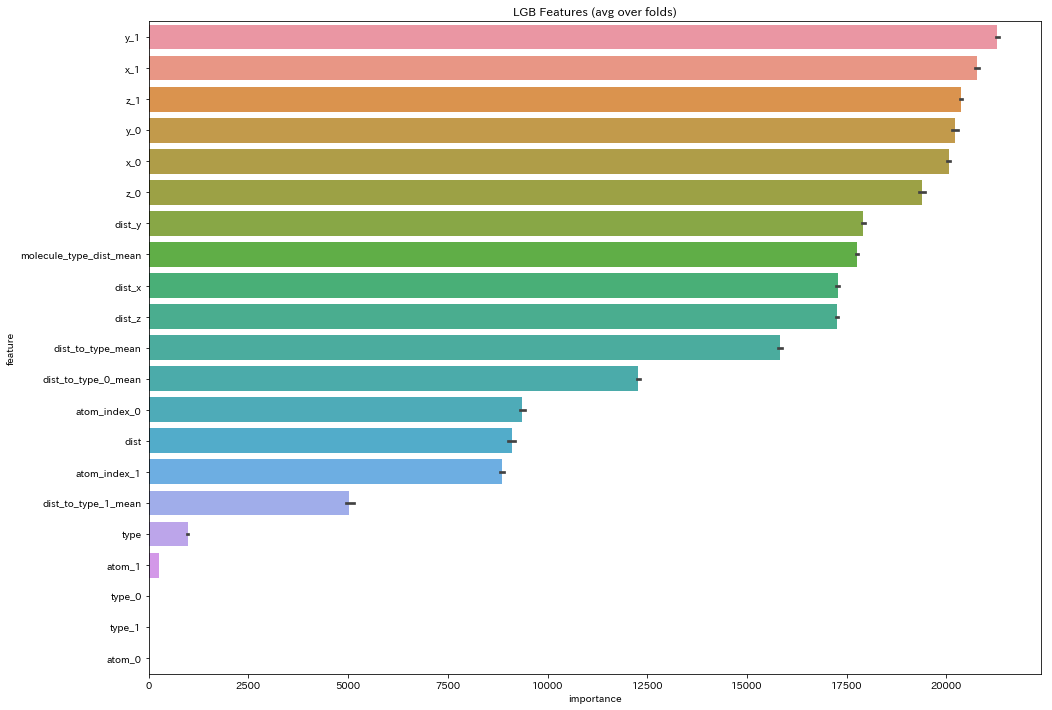

In [29]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 11,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000)

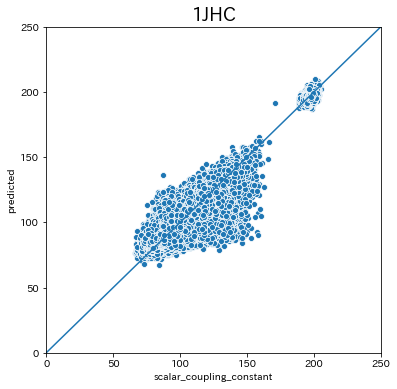

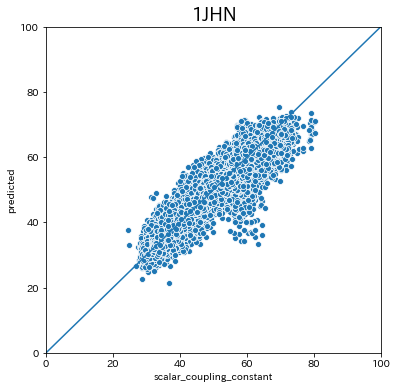

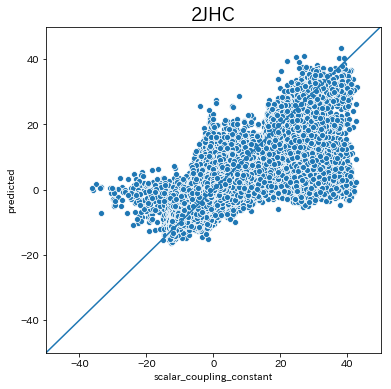

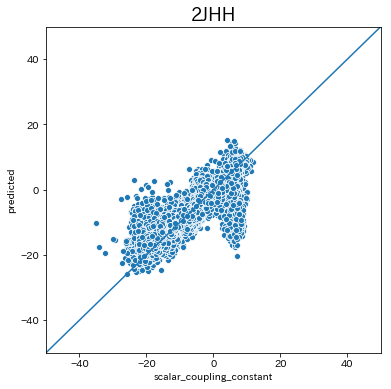

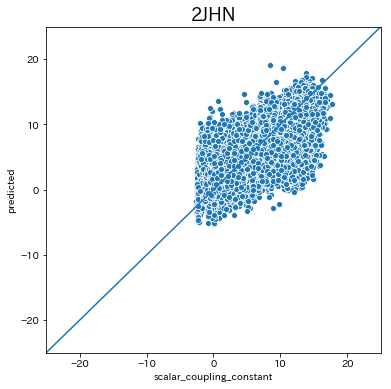

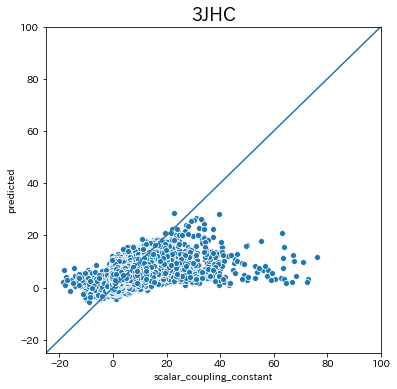

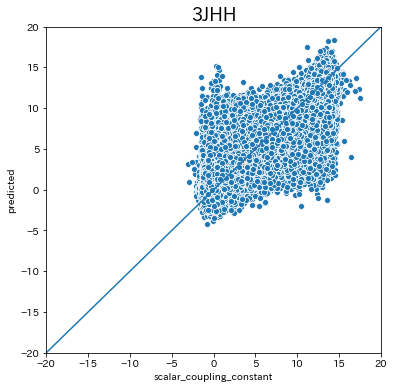

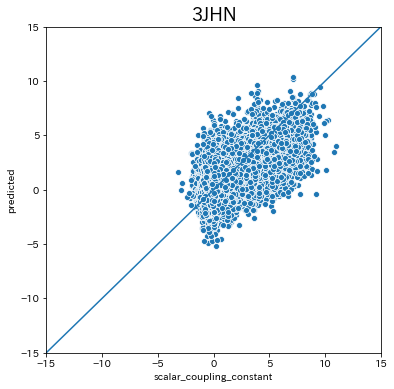

In [31]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict_lgb['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)